# Guider Tracking Introduction
Written by Alex Broguhton

In [2]:
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import matplotlib.animation as animation
import numpy as np
import numpy.ma as ma
import galsim # For the HSM centroid fitting


# **LATISS** (8/16/2023)

In [3]:
h = fits.open("./data/AT_O_20230816_000331_R00_SW0_guider.fits")
N = h[0].header['N_STAMPS']
print(f"{N} stamps in guider sequence.")

298 stamps in guider sequence.


In [4]:
def getCentroidHSM(data):
    cutout = galsim.Image(data) 
    res = galsim.hsm.FindAdaptiveMom(cutout, strict=True)
    return (res.moments_centroid.x, res.moments_centroid.y)

def getCentroid(data, smoothing_sigma=0.0, min_sigma_clipping=3.5):
    from astropy.stats import sigma_clip
    from scipy.ndimage import gaussian_filter

    data = gaussian_filter(data, smoothing_sigma)
    result = sigma_clip(data, sigma=min_sigma_clipping, cenfunc='median', 
                        stdfunc='std',return_bounds=True,maxiters=None)  

    centroid = np.average(np.argwhere(data >= result[2]), 
                          axis=0, 
                          weights = np.sqrt(data[data >= result[2]]) )
    return np.flip(centroid)

def getCentroids(header, data_sections=[[None,None], [None,None]], N=None):
    if N is None:
        N = header[0].header['N_STAMPS']

    mask = np.ones(header[1].data.shape, dtype=bool)
    if not np.all(np.asarray(data_sections).ravel())==None:
        mask[data_sections[1][0]:data_sections[1][1],
             data_sections[0][0]:data_sections[0][1]] = 0

    
    centroid_x = []
    centroid_y = []
    for ext in range(1,N+1):
        data = ma.masked_array(header[ext].data, mask=mask)
        centroid = getCentroid(data)
        centroid_x.append(centroid[0])
        centroid_y.append(centroid[1]) 
    return np.asarray(centroid_x), np.asarray(centroid_y)

def makeMovie(header, data_sections=[[None,None], [None,None]], start_frame=0,
              fps=10, vmin=12500, vmax=13000, skip_frames=[], saveTo=None):
    
    fig = plt.figure( figsize=(8,8) )

    mask = np.ones(header[1].data.shape, dtype=bool)
    if not np.all(np.asarray(data_sections).ravel())==None:
        mask[data_sections[1][0]:data_sections[1][1],
             data_sections[0][0]:data_sections[0][1]] = 0


    initial = ma.masked_array(header[start_frame+1].data, mask=mask)
    plt.imshow(initial)
    N = h[0].header['N_STAMPS'] - start_frame
    centroid = getCentroid(initial)
    im = plt.imshow(initial, origin='lower', vmin=vmin,vmax=vmax)
    sca = plt.scatter(centroid[0], centroid[1], c='r', marker='+', s=20)
    clb = plt.colorbar(im, shrink=.8)
    clb.ax.set_title('ADU')

    def update(ext):
        data = ma.masked_array(header[ext+1].data, mask=mask)
        centroid = getCentroid(data)
        if np.all(np.asarray(data_sections).ravel())==None:
            data = ma.masked_array(header[ext+1].data, mask=~mask)
        im.set_array(data)
        sca.set_offsets([centroid[0], centroid[1]])
        
        return [im, sca]

    a = animation.FuncAnimation(fig, update, frames = N, interval = 1000 / fps)

    if saveTo is not None:
        a.save(saveTo, fps=fps, extra_args=['-vcodec', 'libx264'])
    
    return a

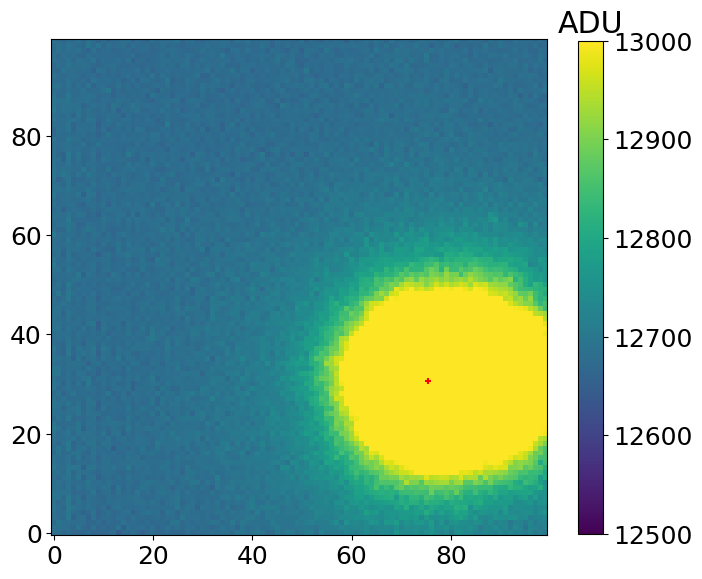

In [5]:
a = makeMovie(h, saveTo="./guider.mp4")

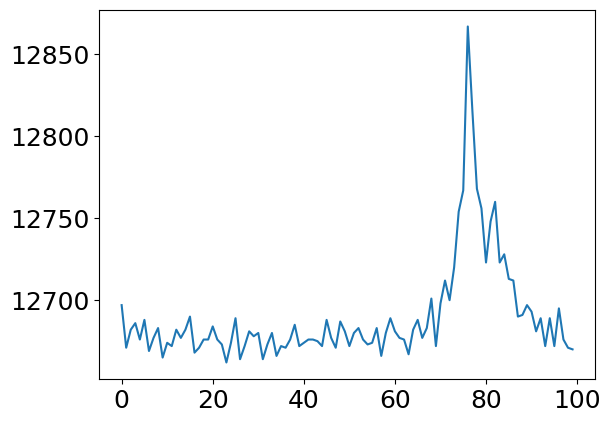

In [6]:
plt.plot(h[5].data[30,:])

12675.943145535071 12676.0 8.065039818323035


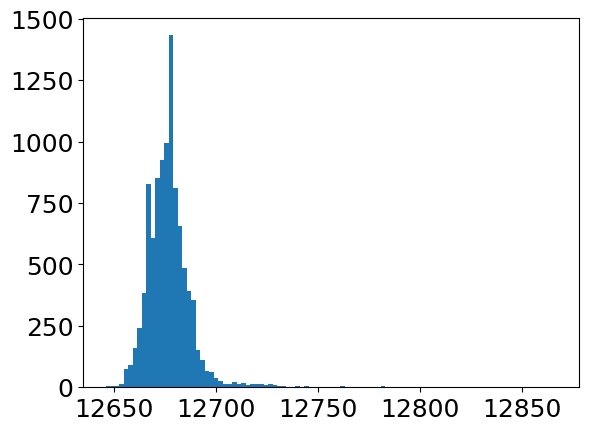

In [33]:
from astropy.stats import sigma_clipped_stats
data = h[5].data
mean, median, stddev = sigma_clipped_stats(data, sigma_upper=3.0, maxiters=None, cenfunc='median', stdfunc='std', std_ddof=0, axis=None, grow=False)

print(mean, median, stddev)

_ = plt.hist(data.ravel()[median < median+2*stddev].ravel(), bins=100)



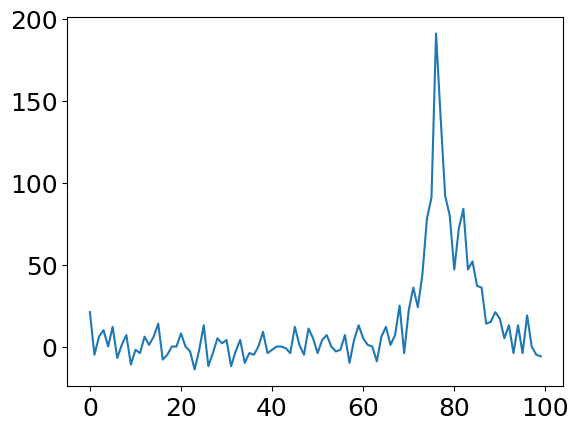

In [37]:
plt.plot(h[5].data[30,:]-median)
S = np.sum(h[5].data[30,:]-median)

In [38]:
S / stddev

168.87703355235274

In [7]:
x,y = getCentroids(h)

# Clip out the odd first exposure
centroid_x=x[1:]
centroid_y=y[1:]

centroids = np.sqrt(centroid_x**2 + centroid_y**2)

Text(0.5, 0, 'SEQ')

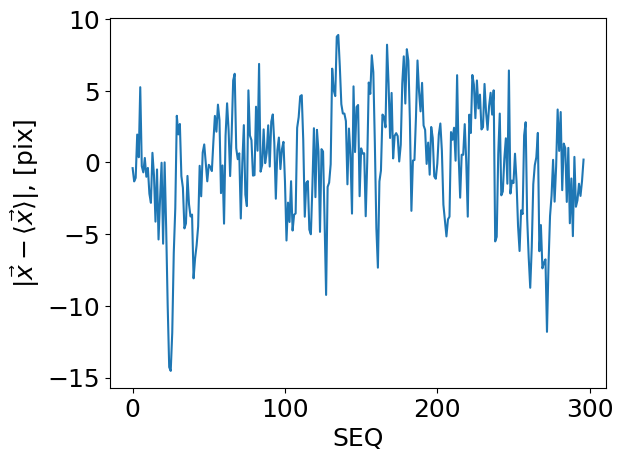

In [8]:
plt.plot(centroids-np.mean(centroids))
plt.ylabel(r"$|\vec{x} - \left \langle \vec{x} \right \rangle|$, [pix]")
plt.xlabel(r"SEQ")

In [13]:
rms = np.sqrt(np.mean((centroids-np.mean(centroids))**2))

In [14]:
rms

3.892561532467634

# **LSSTCam** (11/1/2023)

In [39]:
# Read in a file
h = fits.open("./data/MC_C_20231101_000084_R00_SG1_guider.fits")
N = h[0].header['N_STAMPS']
print(f"{N} stamps in guider sequence.")

24 stamps in guider sequence.


In [40]:
# The LSST data are clipped, and the spots are larger compared to the stamp size,
# so we need a slightly different centroiding algorithm.
def getCentroid(data, sigma_clipping=3.5):
    from astropy.stats import sigma_clipped_stats
    from scipy.ndimage import gaussian_filter

    # Determine the background 
    data_arr = data.ravel()
    mean, median, stddev = sigma_clipped_stats(data_arr[data_arr<np.median(data_arr)], sigma_upper=sigma_clipping, cenfunc='median', stdfunc='std',maxiters=None)  
    threshold = median+stddev
    
    
    data_arr = data >= threshold
    plt.imshow(data)
    initial = ma.masked_array(data, mask=data_arr).ravel()
    plt.imshow(data, origin="lower")
    centroid = np.average(np.argwhere(data >= threshold), 
                          axis=0, 
                          weights = np.sqrt(np.take(data, np.argwhere(data >= threshold))))
    return np.flip(centroid)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of

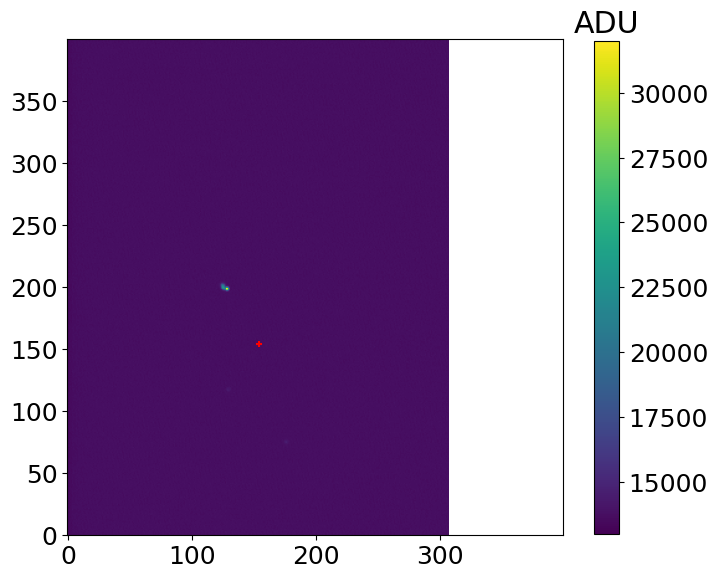

In [41]:
a = makeMovie(h, data_sections=[[0,308], [0,400]], 
              start_frame=4, vmin=13000, vmax=32000,
              fps=1,
              saveTo="./guidertest-lsstcam-11-1-2023.mp4")


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of

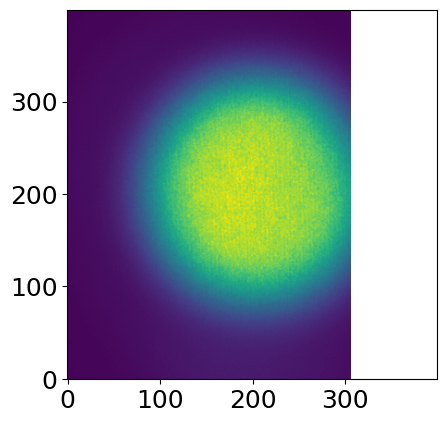

In [46]:
x,y = getCentroids(h[6:], data_sections=[[0,308], [0,399]], N=24-6)

# Clip out the odd first exposure
centroid_x=np.asarray(x)
centroid_y=np.asarray(y)

centroids = np.sqrt(centroid_x**2 + centroid_y**2)

Text(0.5, 0, 'SEQ')

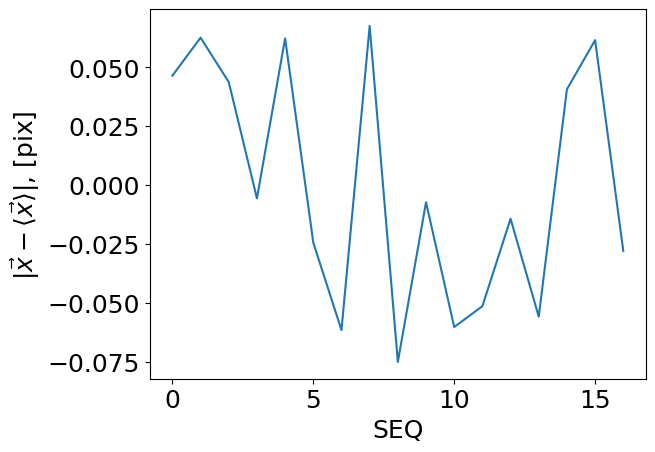

In [47]:
plt.plot(centroids[:-1]-np.mean(centroids[:-1]))
plt.ylabel(r"$|\vec{x} - \left \langle \vec{x} \right \rangle|$, [pix]")
plt.xlabel(r"SEQ")

In [44]:
rms = np.sqrt(np.mean((centroids-np.mean(centroids))**2))

In [45]:
rms

1.6448939376049594